# Evaluate the data with the backend
We are evaluating the gpt integration by simulating student responses from previous real data and comparing the feedback and results with real human grading.

## Load and Prepare Mat/Stat Data

In [1]:
import pandas as pd

In [2]:
# Load and clean tasks_df
tasks_df = pd.read_csv('data/tasks_df.csv')

# Remove rows with `_de` in the `instruction_file_name` to avoid duplicates
tasks_df = tasks_df[~tasks_df['instruction_file_name'].str.contains('_de', na=False)]

# Load other datasets
submissions_df = pd.read_csv('data/submissions_df.csv')
users_df = pd.read_csv('data/users_df.csv')

# Print summaries
print("---Cleaned Tasks---")
print(tasks_df.head())
print(f"Total tasks after removing _de: {len(tasks_df)}")

print("---Submissions---")
print(submissions_df.head())

print("---Users---")
print(users_df.head())


---Cleaned Tasks---
    id            slug  assignment_id  max_points  solution_file_id  \
0  402  1_week1_sta120            302         1.0               606   
1  403  2_week1_sta120            302         1.0               611   
2  753  2_week8_sta120            652         1.0              1261   
3  709  3_week6_sta120            603         1.0              1146   
4  404  3_week1_sta120            302         1.0               617   

  solution_file_name solution_file_mime_type  \
0           script.R              text/plain   
1           script.R              text/plain   
2           script.R              text/plain   
3           script.R              text/plain   
4           script.R              text/plain   

                                            solution  instruction_file_id  \
0  png(file = "solution.png")\nrequire(fields) # ...                  602   
1                                 demo(persp) \n\n\n                  607   
2   png(file="solution.png")\nmu 

In [65]:
print(tasks_df)

      id             slug  assignment_id  max_points  solution_file_id  \
0    402   1_week1_sta120            302         1.0               606   
1    403   2_week1_sta120            302         1.0               611   
2    753   2_week8_sta120            652         1.0              1261   
3    709   3_week6_sta120            603         1.0              1146   
4    404   3_week1_sta120            302         1.0               617   
..   ...              ...            ...         ...               ...   
157  860  3_week10_mat183            754         1.0              1553   
159  861  4_week10_mat183            754         2.0              1559   
161  862  1_week11_mat183            755         1.0              1565   
164  864  3_week11_mat183            755         1.0              1577   
166  865  4_week11_mat183            755         2.0              1583   

    solution_file_name solution_file_mime_type  \
0             script.R              text/plain   
1          

### Integrity Checks


In [3]:
# Check for mismatches in slugs and course_slug
tasks_with_mismatch = tasks_df[
    ((tasks_df['slug'].str.contains('sta')) & (tasks_df['course_slug'] == 'fs24-mat183')) |
    ((tasks_df['slug'].str.contains('mat')) & (tasks_df['course_slug'] == 'fs24-sta120'))
]

# Print mismatches, if any
if not tasks_with_mismatch.empty:
    print("Mismatches found between slug and course_slug:")
    print(tasks_with_mismatch)
else:
    print("No mismatches found between slug and course_slug.")


No mismatches found between slug and course_slug.


In [4]:
# Merge submissions and tasks
combined_data = submissions_df.merge(tasks_df, left_on="task_id", right_on="id")

# Check for mismatches in slug and course_slug
merged_mismatches = combined_data[
    ((combined_data['slug'].str.contains('sta')) & (combined_data['course_slug'] == 'fs24-mat183')) |
    ((combined_data['slug'].str.contains('mat')) & (combined_data['course_slug'] == 'fs24-sta120'))
]

# Print mismatches after the merge
if not merged_mismatches.empty:
    print("Mismatches found in combined_data after the merge:")
    print(merged_mismatches[['task_id', 'slug', 'course_slug']])
else:
    print("No mismatches found in combined_data after the merge.")
    



No mismatches found in combined_data after the merge.


In [5]:
print(len(combined_data))
print(len(submissions_df))

55289
55289


In [6]:
# Count duplicate task IDs in tasks_df
duplicate_task_ids = tasks_df['id'].duplicated().sum()
print(f"Duplicate IDs in tasks_df: {duplicate_task_ids}")

Duplicate IDs in tasks_df: 0


## Load and Prepare Banking Data

In [7]:


def filter_grading_data_by_points(grading_data: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the grading data to remove rows where points are not divisible by 0.5.
    
    Args:
        grading_data (pd.DataFrame): The DataFrame containing grading data, including a 'points_assigned' column.
    
    Returns:
        pd.DataFrame: The filtered DataFrame with only rows where points are divisible by 0.5.
    """
    # Ensure the 'points_assigned' column exists
    if 'points_assigned' not in grading_data.columns:
        raise ValueError("The 'points_assigned' column is missing from the grading data.")
    
    # Filter rows where 'points_assigned' is divisible by 0.5
    filtered_data = grading_data[grading_data['points_assigned'] % 0.5 == 0]
    
    return filtered_data


In [8]:
# Load datasets
exam_data = pd.read_csv("data_banking/exam_data.csv")
grading_data = pd.read_csv("data_banking/grading.csv")
responses_data = pd.read_csv("data_banking/responses.csv")

# Filter grading data to remove inconsistent points
grading_data = filter_grading_data_by_points(grading_data)

# Transform the banking data into the required format
banking_data = []

for _, response in responses_data.iterrows():
    # Match exam data by exam_id, exercise_id, and exercise_index
    matched_exam_data = exam_data[
        (exam_data["exam_id"] == response["exam_id"]) &
        (exam_data["exercise_id"] == response["exercise_id"]) &
        (exam_data["exercise_index"] == response["exercise_index"])
    ]

    # Ensure there's a match
    if matched_exam_data.empty:
        print(f"No match found in exam_data for response: {response['answer_identifier']}")
        continue
        
    rubrics_key = f"{response['exercise_id']}_{response['exercise_index']}"
    rubrics = []
    
    for _, rubric in matched_exam_data.iterrows():
        # Match grading data by answer_identifier and rubric_id
        points_assigned = grading_data.loc[
            (grading_data["answer_identifier"] == response["answer_identifier"]) &
            (grading_data["rubric_id"] == rubric["rubric_id"]),
            "points_assigned"
        ].values
        rubrics.append({
            "id": str(rubric["rubric_id"]),
            "title": rubric["rubric_title"],
            "points": rubric["rubric_points"],
            "points_assigned": round(points_assigned[0] * 2) / 2 if len(points_assigned) > 0 else 0  # Round to nearest 0.5
        })
        
    # Skip empty student answers as they are trivially 0 points
    if not response["student_answer"] or response["student_answer"] is None or pd.isna(response["student_answer"]) or response["student_answer"] == "":
        continue
    
    if len(rubrics) == 0:
        print(f"No rubrics found for response: {response['answer_identifier']}")
        
    banking_data.append({
        "id": response["answer_identifier"],  # Unique identifier for submission
        "instruction": matched_exam_data.iloc[0]["exercise_questions"],
        "points": sum([r["points_assigned"] for r in rubrics]),  # Total points assigned
        "valid": True,
        "solution": None, # No solution provided, Rubrics are used for evaluation
        "evaluation_id": response["exam_id"],  # Use exam_id as evaluation_id
        "content": response["student_answer"],  # Student's submission
        "task_id": f"banking_{response['exercise_id']}_{response['exercise_index']}",  # Unique task ID
        "maxPoints": matched_exam_data.iloc[0]["exercise_points"],  # Max points for the exercise
        "minPoints": 0,  # Default minPoints
        "pointStep": 0.5,  # Default pointStep
        "course_slug": "fs24-banking",  # Course slug for banking dataset
        "rubrics": rubrics,  # Rubrics for this submission
    })

# Convert to DataFrame
banking_df = pd.DataFrame(banking_data)


In [10]:
print(f"Missing max_points in tasks_df: {tasks_df['max_points'].isna().sum()}")
print(f"Missing maxPoints in banking_df: {banking_df['maxPoints'].isna().sum()}")


Missing max_points in tasks_df: 0
Missing maxPoints in banking_df: 0


### Stratified Sampling

Total sampled submissions (Stat): 100
Total unique exercises (Stat): 10
Total sampled submissions (Mat): 100
Total unique exercises (Mat): 10
Total sampled submissions (Banking): 100
Total unique exercises (Banking): 10


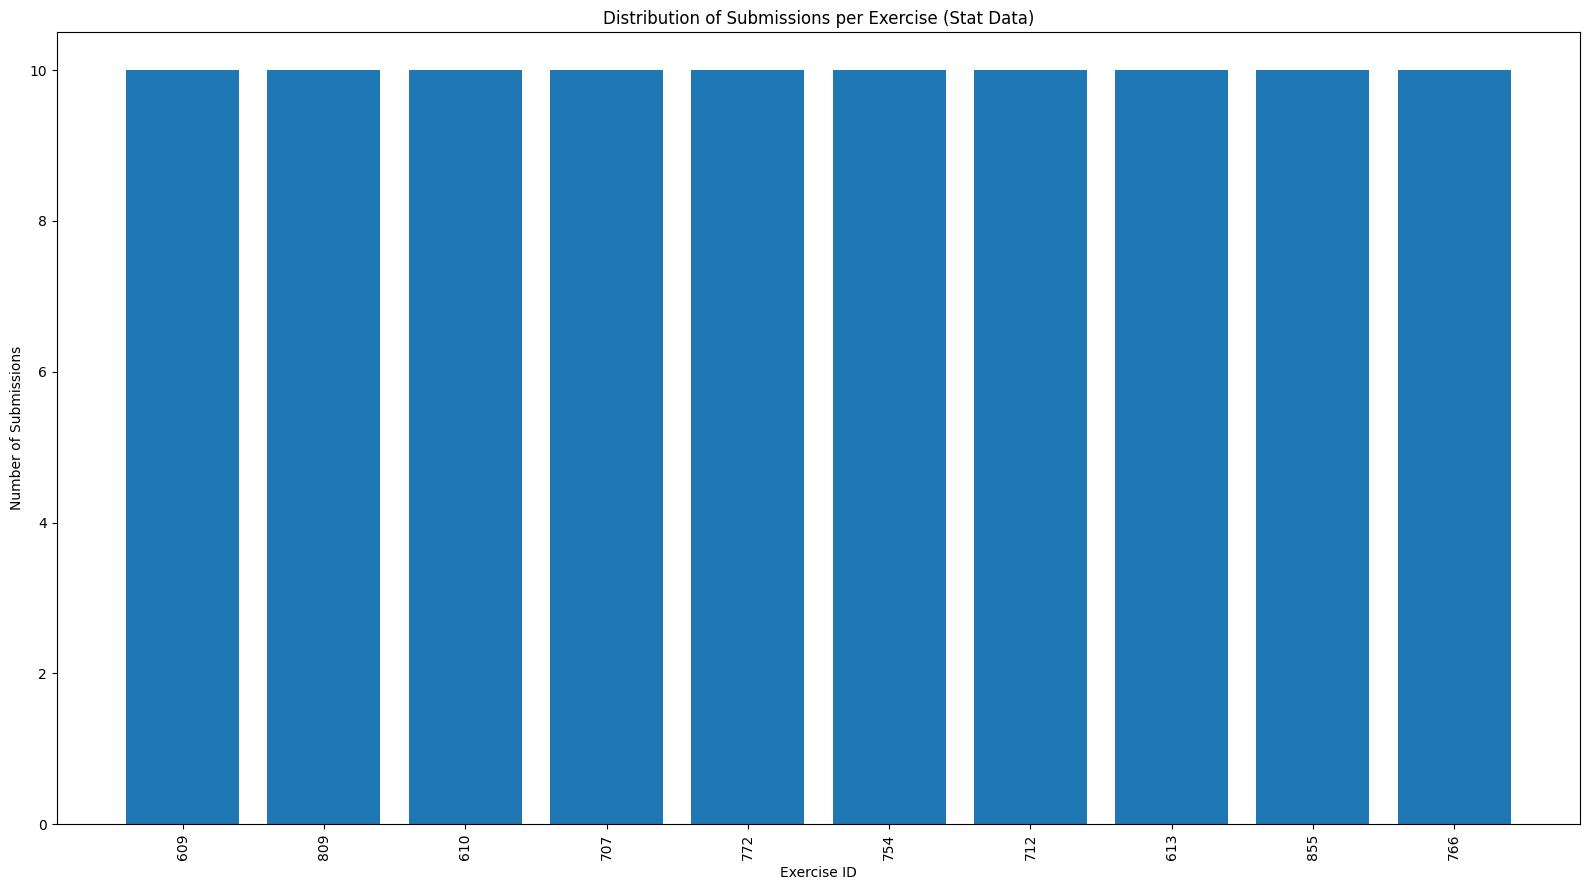

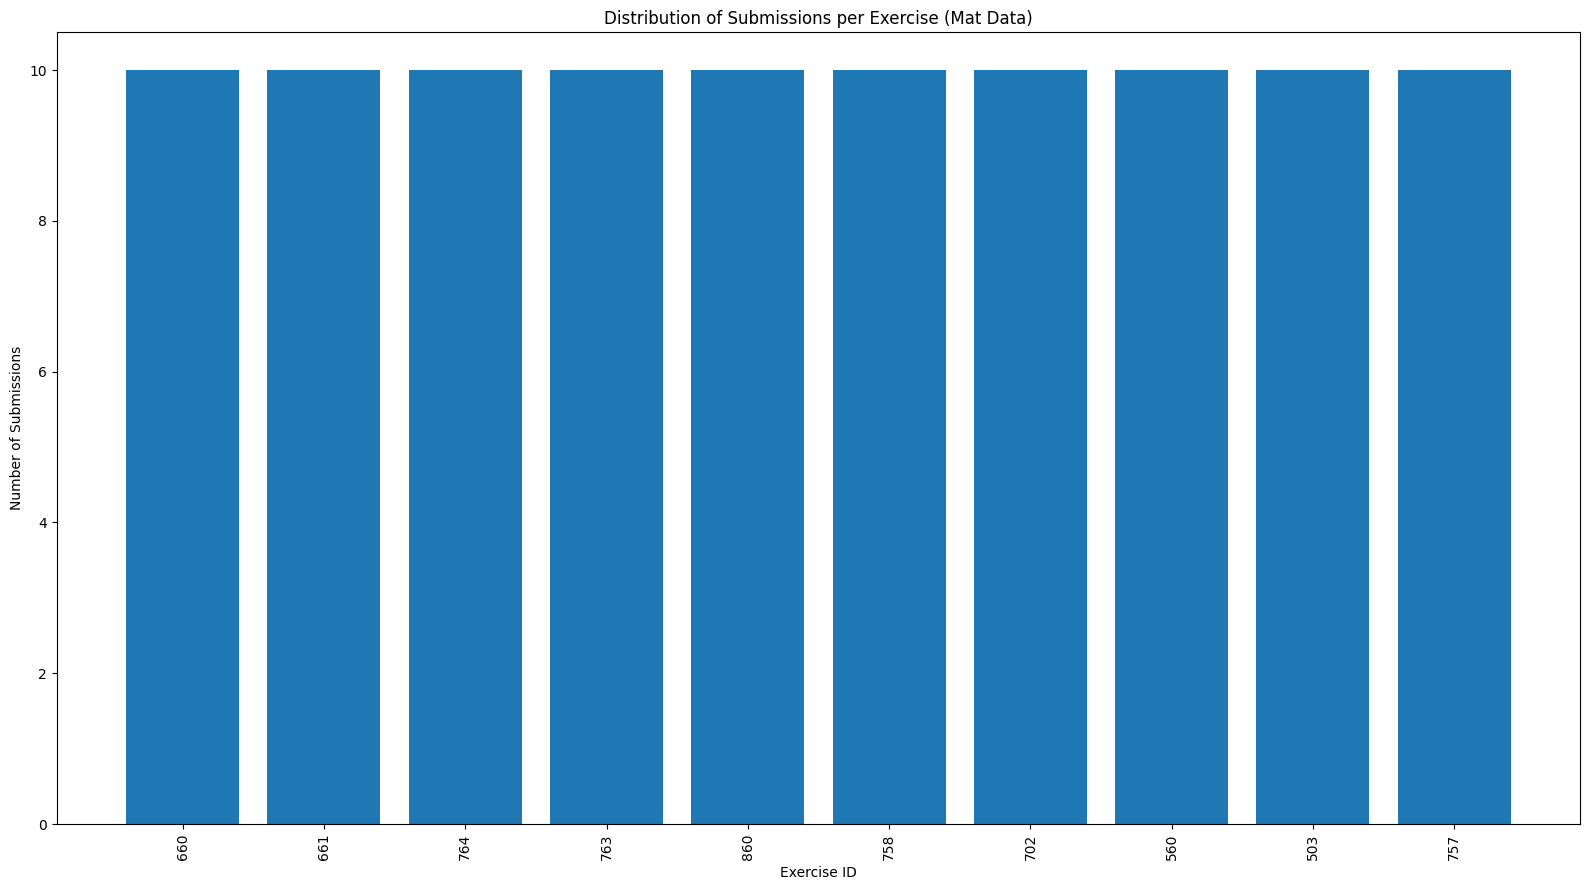

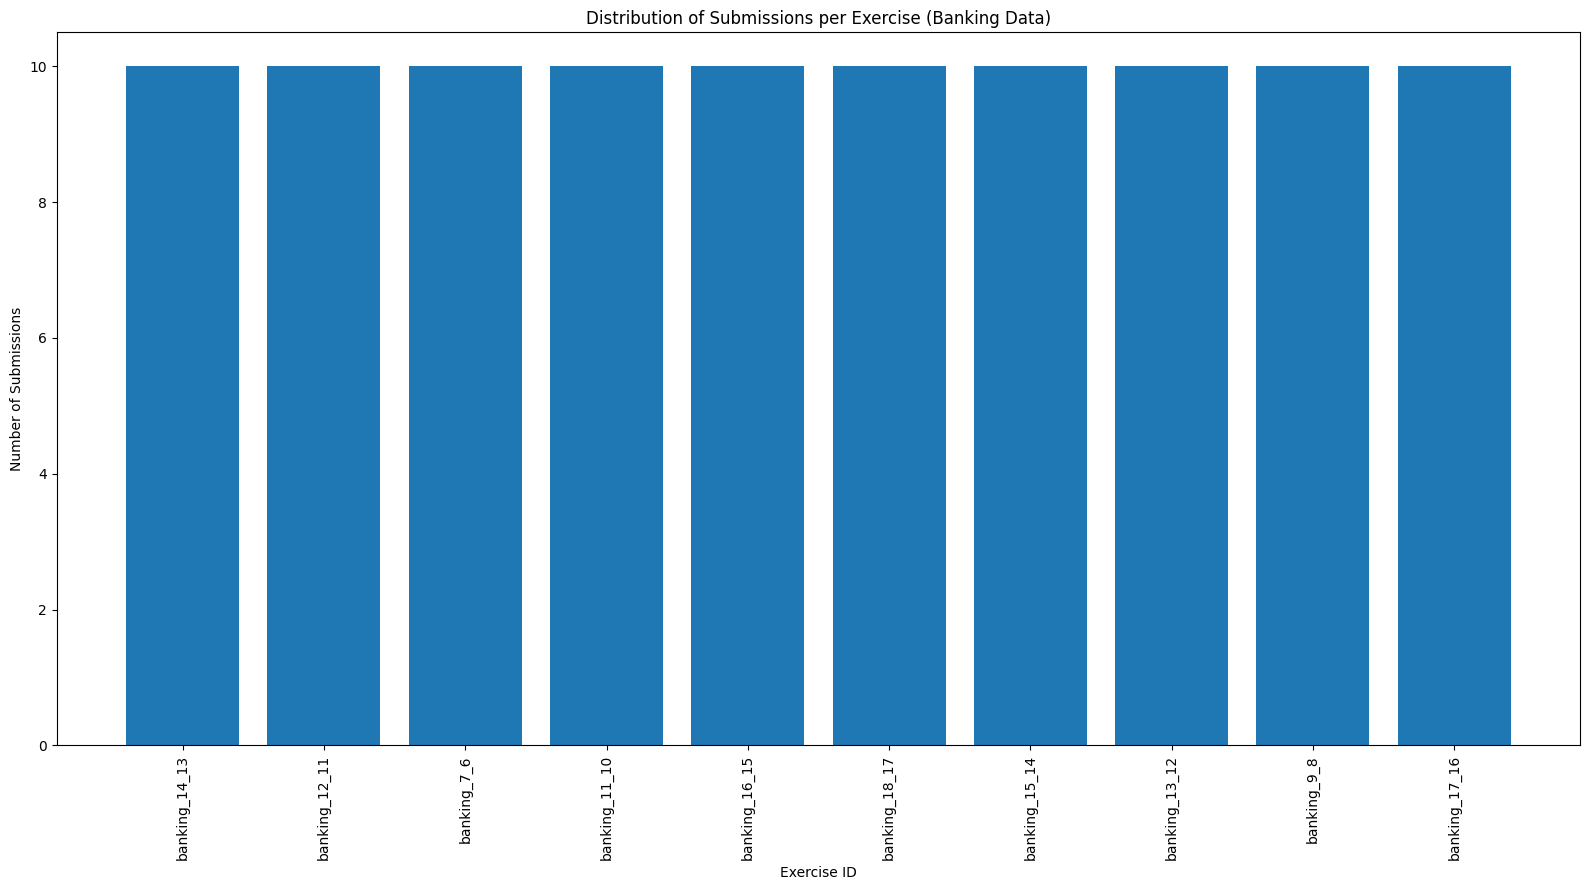

Unique exercises in Stat set: 10
Unique exercises in Mat set: 10
Unique exercises in Banking set: 10


In [11]:
import matplotlib.pyplot as plt
from helpers.stratified_sample import stratified_random_sample

# Combine submissions and tasks into one dataset
combined_data = submissions_df.merge(tasks_df, left_on="task_id", right_on="id")

combined_data.rename(columns={"max_points": "maxPoints"}, inplace=True)

# Rename columns for consistency with other datasets
banking_df.rename(columns={"id": "id_x"}, inplace=True)
# Combine with existing data
combined_data = pd.concat([combined_data, banking_df], ignore_index=True)
# Rename columns for consistent field names

# Convert to a list of dictionaries for stratified sampling
combined_data_dict = combined_data.to_dict(orient="records")

# Apply stratified sampling
sampled_data_by_course = stratified_random_sample(
    combined_data_dict,
    num_groups=6,  # 6 Groups of maxPoints to diversify difficulty
    exercise_sample_size=10,  # Ensure diversity in exercises
    submissions_per_exercise=10  # Uniform submissions per exercise
)

# Separate sampled data into stat, mat, and banking
evaluation_data_stat_rand = sampled_data_by_course.get("fs24-sta120", [])
evaluation_data_mat_rand = sampled_data_by_course.get("fs24-mat183", [])
evaluation_data_banking_rand = sampled_data_by_course.get("fs24-banking", [])

# Check stratified sampling results
def count_submissions_by_exercise(data):
    counts = {}
    for entry in data:
        task_id = entry["task_id"]
        counts[task_id] = counts.get(task_id, 0) + 1
    return counts

# Count submissions per exercise for each course
counts_stat = count_submissions_by_exercise(evaluation_data_stat_rand)
counts_mat = count_submissions_by_exercise(evaluation_data_mat_rand)
counts_banking = count_submissions_by_exercise(evaluation_data_banking_rand)

# Count unique exercises
unique_exercises_stat = len(counts_stat)
unique_exercises_mat = len(counts_mat)
unique_exercises_banking = len(counts_banking)

# Print results
print(f"Total sampled submissions (Stat): {len(evaluation_data_stat_rand)}")
print(f"Total unique exercises (Stat): {unique_exercises_stat}")
print(f"Total sampled submissions (Mat): {len(evaluation_data_mat_rand)}")
print(f"Total unique exercises (Mat): {unique_exercises_mat}")
print(f"Total sampled submissions (Banking): {len(evaluation_data_banking_rand)}")
print(f"Total unique exercises (Banking): {unique_exercises_banking}")

# Convert counts to DataFrames for visualization
counts_stat_df = pd.DataFrame(list(counts_stat.items()), columns=["Exercise", "Submissions"])
counts_mat_df = pd.DataFrame(list(counts_mat.items()), columns=["Exercise", "Submissions"])
counts_banking_df = pd.DataFrame(list(counts_banking.items()), columns=["Exercise", "Submissions"])

# Plot the distribution of submissions per exercise for each course
def plot_submissions_distribution(df, title):
    plt.figure(figsize=(16, 9))
    plt.bar(df["Exercise"].astype(str), df["Submissions"])
    plt.xlabel("Exercise ID")
    plt.ylabel("Number of Submissions")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_submissions_distribution(counts_stat_df, "Distribution of Submissions per Exercise (Stat Data)")
plot_submissions_distribution(counts_mat_df, "Distribution of Submissions per Exercise (Mat Data)")
plot_submissions_distribution(counts_banking_df, "Distribution of Submissions per Exercise (Banking Data)")

# Final integrity checks
print(f"Unique exercises in Stat set: {len(set(d['task_id'] for d in evaluation_data_stat_rand))}")
print(f"Unique exercises in Mat set: {len(set(d['task_id'] for d in evaluation_data_mat_rand))}")
print(f"Unique exercises in Banking set: {len(set(d['task_id'] for d in evaluation_data_banking_rand))}")


In [34]:
import os
from datetime import datetime

# Convert the datasets to DataFrames
stat_df = pd.DataFrame(evaluation_data_stat_rand)
mat_df = pd.DataFrame(evaluation_data_mat_rand)
banking_df = pd.DataFrame(evaluation_data_banking_rand)

# Create a folder for outputs
output_folder = "stratified_samples"
os.makedirs(output_folder, exist_ok=True)

# Add a timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save files with timestamp
stat_df.to_csv(f"{output_folder}/evaluation_data_stat_rand_{timestamp}.csv", index=False)
mat_df.to_csv(f"{output_folder}/evaluation_data_mat_rand_{timestamp}.csv", index=False)
banking_df.to_csv(f"{output_folder}/evaluation_data_banking_rand_{timestamp}.csv", index=False)

print("Datasets saved with timestamps.")


Datasets saved with timestamps.


# Evaluation
We use parallelism here to speed up the evaluation process. We evaluate the submissions using the LLM and compare the results with the human-assigned points.

In [13]:
def calculate_weighted_accuracy(data):
    total_weighted_error = 0
    total_weight = 0

    for entry in data:
        human_points = entry['human_points']
        llm_points = entry['gpt_points']
        max_points = entry['submission']['maxPoints']
        
        if max_points == 0:
            continue

        weight = 1 / max_points  # Inverse weighting by maxPoints
        error = abs(human_points - llm_points) / max_points

        total_weighted_error += weight * error
        total_weight += weight

    return 1 - (total_weighted_error / total_weight if total_weight > 0 else 0)


def calculate_bias(tracker):
    """
    Calculate overestimation and underestimation bias from the tracker.
    """
    over_bias = 0
    under_bias = 0
    total_tasks = len(tracker)

    for entry in tracker:
        human_points = entry["human_points"]
        llm_points = entry["gpt_points"]
        diff = llm_points - human_points

        if diff > 0:
            over_bias += diff
        else:
            under_bias += abs(diff)

    over_bias = over_bias / total_tasks if total_tasks > 0 else 0
    under_bias = under_bias / total_tasks if total_tasks > 0 else 0

    return {"overestimation": over_bias, "underestimation": under_bias}


In [81]:
import concurrent.futures
import random

# Careful not to use too many threads due to rate limiting
def parallel_evaluate(data, func, num_threads=4, batch_size=100, solution=False, cot=False, voting=1, few_shot_examples=None):
    """
    Parallelizes the evaluation process using threads.
    """
    random.shuffle(data)
    data_batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

    combined_tracker = []
    combined_logs = []
    batch_accuracies = []
    combined_biases = {"overestimation": 0, "underestimation": 0}
    total_batches = 0

    def wrapper(batch):
        """
        Wrapper to pass additional arguments to func.
        """
        return func(batch, solution, cot, voting, few_shot_examples)

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(wrapper, data_batches))

    for res_tracker, batch_accuracy, res_logs, bias in results:
        combined_tracker.extend(res_tracker)
        combined_logs.extend(res_logs)
        batch_accuracies.append(batch_accuracy)

        # Combine biases
        combined_biases["overestimation"] += bias["overestimation"]
        combined_biases["underestimation"] += bias["underestimation"]
        total_batches += 1

    # Finalize biases by averaging
    if total_batches > 0:
        combined_biases["overestimation"] /= total_batches
        combined_biases["underestimation"] /= total_batches

    overall_accuracy = sum(batch_accuracies) / len(batch_accuracies) if batch_accuracies else 0

    return combined_tracker, overall_accuracy, combined_logs, combined_biases


In [235]:
import copy
import requests
from tqdm.notebook import tqdm


# Function to evaluate the submissions using the LLM
def evaluate(to_evaluate, solution=False, cot=False, voting=1, few_shot_examples=None):
    EVALUATION_URL = "http://localhost:4000/evaluate"
    tracker = []
    accuracy_tracker = []
    logs = []

    def calculate_accuracy(human_points, llm_points, max_points):
        if max_points == 0:
            return 1  # Avoid division by zero
        diff = abs(human_points - llm_points)
        return 1 - diff / max_points

    for idx, submission in enumerate(tqdm(to_evaluate, desc="Evaluating submissions"), start=1):
        # Prepare payload for the API
        payload = prepare_payload(submission, solution=solution, cot=cot, voting=voting, few_shot_examples=few_shot_examples)
        
        try:
            # Make API call for evaluation
            res = requests.post(EVALUATION_URL, json=payload, headers={"Content-Type": "application/json"})
            res.raise_for_status()
            evaluation_result = res.json()
            

            # Extract LLM-assigned points and rubric data
            llm_points = evaluation_result.get("points", 0)
            max_points = payload["maxPoints"]
            human_points = submission.get("human_points", 0)

            # Calculate accuracy
            accuracy = calculate_accuracy(human_points, llm_points, max_points)

            tracker.append({
                "human_points": human_points,
                "gpt_points": llm_points,
                "accuracy": accuracy,
                "evaluation_result": evaluation_result,
                "submission": submission,  # Store the original submission
            })
            accuracy_tracker.append(accuracy)

            # Add logs
            logs.append(f"Submission {idx} Result: {evaluation_result}")
            logs.append(f"Human Points: {human_points}, GPT Points: {llm_points}")
            logs.append(f"Accuracy: {accuracy:.2%}")
        except requests.exceptions.RequestException as e:
            print(f"Error evaluating submission {idx}: {e}")
            print(f"Invalid payload?: {payload}")
            logs.append(f"Error evaluating submission {idx}: {e}")

    # Calculate metrics
    accuracy = calculate_weighted_accuracy(tracker)
    bias = calculate_bias(tracker)

    return tracker, accuracy, logs, bias


def prepare_payload(submission, solution=False, cot=False, voting=1, few_shot_examples=None):
    """
    Prepare the payload for a specific submission, ensuring only relevant few-shot examples are included.
    """
    # Create a deep copy to avoid modifying the original
    submission_copy = copy.deepcopy(submission)

    # Adjust optional fields
    if not solution:
        submission_copy.pop("modelSolution", "No solution provided")  # Remove modelSolution if not using solution
        submission_copy.pop("rubrics", [])  # Remove rubrics if not using solution

    # Add chain of thought and voting parameters
    submission_copy["chainOfThought"] = cot
    submission_copy["votingCount"] = voting

    # Convert np.float64 to float for numeric fields
    submission_copy["maxPoints"] = float(submission_copy.get("maxPoints", 0))
    submission_copy["minPoints"] = float(submission_copy.get("minPoints", 0))
    submission_copy["pointStep"] = float(submission_copy.get("pointStep", 0))
    
    # Add few-shot examples if provided and if task ID matches
    task_id = submission_copy["task_id"]
    if few_shot_examples and task_id in few_shot_examples:
        submission_copy["fewShotExamples"] = few_shot_examples[task_id]  # Only include examples for this task_id

    return {
        "question": submission_copy["question"],
        "answer": submission_copy["answer"],
        "rubrics": submission_copy.get("rubrics", []),
        "modelSolution": submission_copy.get("modelSolution", "No Solution Provided"),
        "maxPoints": submission_copy["maxPoints"],
        "minPoints": submission_copy["minPoints"],
        "pointStep": submission_copy["pointStep"],
        "temperature": 0.2,
        "llmType": "gpt",
        "chainOfThought": cot,
        "votingCount": voting,
        "fewShotExamples": submission_copy.get("fewShotExamples", None),  # Include task-specific few-shot examples
    }



## Setup

In [82]:

# Parallel evaluation setup
num_threads = 4  # Adjust based on your CPU cores, keep it at max 4 due to rate limits.
batch_size = 25

## Evaluate each case
We evaluate the submissions using different strategies to see how they affect the accuracy of the LLM.

### Without Voting, CoT and Solutions
This represents the most basic evaluation setup, accuracy should be lowest here.


In [16]:
# evaluate random subset of stat without including solutions
bank_tracker_no_solutions, bank_accuracy_no_solutions, bank_logs_no_solutions, bank_bias_no_solutions = parallel_evaluate(
    evaluation_data_banking_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size
)



Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# evaluate random subset of stat without including solutions
stat_tracker_no_solutions, stat_accuracy_no_solutions, stat_logs_no_solutions, stat_bias_no_solutions = parallel_evaluate(
    evaluation_data_stat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size
)

In [22]:
mat_tracker_no_solutions, mat_accuracy_no_solutions, mat_logs_no_solutions, mat_bias_no_solutions = parallel_evaluate(evaluation_data_mat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size)


Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

### With Solutions
We add the solutions to the evaluation data to see how it affects the accuracy of the LLM.

In [31]:

bank_tracker, bank_accuracy, bank_logs, bank_bias = parallel_evaluate(evaluation_data_banking_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True)

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

In [26]:

stat_tracker, stat_accuracy, stat_logs, stat_bias = parallel_evaluate(evaluation_data_stat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True)

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

In [28]:
mat_tracker, mat_accuracy, mat_logs, mat_bias = parallel_evaluate(evaluation_data_mat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True)

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

### With Solutions and Voting
Here we add voting, meaning we evaluate the submissions multiple times and take the average of the points assigned by the LLM. This happens in the backend.

In [98]:
num_threads = 2 # Due to rate limits we should not go over 2, voting makes more calls
batch_size = 50 # 100/2

In [35]:

bank_tracker_voting, bank_accuracy_voting, bank_logs_voting, bank_bias_voting = parallel_evaluate(evaluation_data_banking_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3)


Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

In [38]:
stat_tracker_voting, stat_accuracy_voting, stat_logs_voting, state_bias_voting = parallel_evaluate(evaluation_data_stat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3)

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

In [47]:
mat_tracker_voting, mat_accuracy_voting, mat_logs_voting, mat_bias_voting = parallel_evaluate(evaluation_data_mat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3)

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

### With Solutions, Voting and CoT

In [52]:
bank_tracker_cot, bank_accuracy_cot, bank_logs_cot, bank_bias_cot = parallel_evaluate(evaluation_data_banking_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=True)

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

In [56]:
stat_tracker_cot, stat_accuracy_cot, stat_logs_cot, stat_bias_cot = parallel_evaluate(evaluation_data_stat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=True)

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

In [60]:
mat_tracker_cot, mat_accuracy_cot, mat_logs_cot, mat_bias_cot = parallel_evaluate(evaluation_data_mat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=True)

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

### With Solutions, Voting, CoT and Few-Shot

In [99]:
from collections import defaultdict

# Filter remaining submissions not in the stratified samples
def filter_remaining_submissions(all_data, stratified_samples, course_slug):
    """
    Filter submissions not included in the stratified samples and ensure they belong to the correct course.

    Args:
    - all_data: List of all submissions.
    - stratified_samples: List of submissions included in the stratified test sets.
    - course_slug: The course slug to filter for (e.g., "fs24-sta120" or "fs24-mat183").

    Returns:
    - Remaining submissions grouped by task_id.
    """
    stratified_ids = {entry["id_x"] for entry in stratified_samples}
    remaining_data = [
        entry for entry in all_data
        if entry["id_x"] not in stratified_ids and entry["course_slug"] == course_slug
    ]

    # Group remaining submissions by task_id
    grouped_data = defaultdict(list)
    for entry in remaining_data:
        grouped_data[entry["task_id"]].append(entry)

    return grouped_data

# Get remaining submissions for Stat and Mat datasets
remaining_data_stat = filter_remaining_submissions(combined_data_dict, evaluation_data_stat_rand, "fs24-sta120")
remaining_data_mat = filter_remaining_submissions(combined_data_dict, evaluation_data_mat_rand, "fs24-mat183")
remaining_data_banking = filter_remaining_submissions(combined_data_dict, evaluation_data_banking_rand, "fs24-banking")

print(f"Remaining submissions (Stat): {sum(len(v) for v in remaining_data_stat.values())}")
print(f"Remaining submissions (Mat): {sum(len(v) for v in remaining_data_mat.values())}")
print(f"Remaining submissions (Banking): {sum(len(v) for v in remaining_data_banking.values())}")

print(f"Total submissions to evaluate (Stat): {len(evaluation_data_stat_rand)}")
print(f"Total submissions to evaluate (Mat): {len(evaluation_data_mat_rand)}")
print(f"Total submissions to evaluate (Banking): {len(evaluation_data_banking_rand)}")



Remaining submissions (Stat): 18175
Remaining submissions (Mat): 36922
Remaining submissions (Banking): 3554
Total submissions to evaluate (Stat): 100
Total submissions to evaluate (Mat): 100
Total submissions to evaluate (Banking): 100


In [211]:
def prepare_few_shot_examples_for_stat_mat(stratified_data, remaining_data):
    """
    Prepares Few-Shot examples from the remaining submissions for exercises included in the stratified data.

    Args:
    - stratified_data: List of submissions in the stratified sample.
    - remaining_data: Dictionary of remaining submissions grouped by task_id.

    Returns:
    - Few-Shot examples for exercises in the stratified sample, including highest, lowest, and intermediate points.
    """
    # Get the set of task_ids included in the stratified data
    stratified_task_ids = {entry["task_id"] for entry in stratified_data}

    few_shot_examples = {}

    for task_id in stratified_task_ids:
        # Get submissions for this task_id from the remaining data
        submissions = remaining_data.get(task_id, [])

        # Sort submissions by points
        sorted_submissions = sorted(submissions, key=lambda x: x["points"])

        # Prepare few-shot examples based on the number of available submissions
        if len(sorted_submissions) >= 3:
            # Use highest, lowest, and intermediate points
            highest = sorted_submissions[-1]
            lowest = sorted_submissions[0]
            intermediate = sorted_submissions[len(sorted_submissions) // 2]
            few_shot_examples[task_id] = [
                {
                    "answer": highest["content"],
                    "points": str(highest["points"]),
                },
                {
                    "answer": intermediate["content"],
                    "points": str(intermediate["points"]),
                },
                {
                    "answer": lowest["content"],
                    "points": str(lowest["points"]),
                },
            ]
        elif len(sorted_submissions) == 2:
            # Use highest and lowest, duplicate the intermediate
            highest = sorted_submissions[-1]
            lowest = sorted_submissions[0]
            few_shot_examples[task_id] = [
                {
                    "answer": highest["content"],
                    "points": str(highest["points"]),
                },
                {
                    "answer": lowest["content"],
                    "points": str(lowest["points"]),
                },
            ]
        elif len(sorted_submissions) == 1:
            # Use the only available submission
            highest = sorted_submissions[0]
            few_shot_examples[task_id] = [
                {
                    "answer": highest["content"],
                    "points": str(highest["points"]),
                }
            ]
        # If no submissions are available, skip this task_id
        else:
            continue

    return few_shot_examples


In [212]:
import json

def prepare_few_shot_examples_for_banking(stratified_data, remaining_data):
    """
    Prepares Few-Shot examples from the remaining submissions for exercises included in the stratified data.

    Args:
    - stratified_data: List of submissions in the stratified sample.
    - remaining_data: Dictionary of remaining submissions grouped by task_id.

    Returns:
    - Few-Shot examples for exercises in the stratified sample, including highest, lowest, and intermediate points.
      Each example contains rubric-level human grading as a JSON string.
    """
    # Get the set of task_ids included in the stratified data
    stratified_task_ids = {entry["task_id"] for entry in stratified_data}

    few_shot_examples = {}

    for task_id in stratified_task_ids:
        # Get submissions for this task_id from the remaining data
        submissions = remaining_data.get(task_id, [])

        # Calculate total human-assigned points for each submission
        for submission in submissions:
            submission["human_points"] = sum(
                r.get("points_assigned", 0) for r in submission.get("rubrics", [])
            )

        # Sort submissions by total human-assigned points
        sorted_submissions = sorted(submissions, key=lambda x: x["human_points"])

        # Prepare few-shot examples based on the number of available submissions
        if len(sorted_submissions) >= 3:
            # Use highest, lowest, and intermediate points
            highest = sorted_submissions[-1]
            lowest = sorted_submissions[0]
            intermediate = sorted_submissions[len(sorted_submissions) // 2]
            few_shot_examples[task_id] = [
                {
                    "answer": highest["content"],
                    "points": json.dumps([
                        {"id": rubric["id"], "points_assigned": rubric["points_assigned"]}
                        for rubric in highest.get("rubrics", [])
                    ]),
                },
                {
                    "answer": intermediate["content"],
                    "points": json.dumps([
                        {"id": rubric["id"], "points_assigned": rubric["points_assigned"]}
                        for rubric in intermediate.get("rubrics", [])
                    ]),
                },
                {
                    "answer": lowest["content"],
                    "points": json.dumps([
                        {"id": rubric["id"], "points_assigned": rubric["points_assigned"]}
                        for rubric in lowest.get("rubrics", [])
                    ]),
                },
            ]
        elif len(sorted_submissions) == 2:
            # Use highest and lowest, duplicate the intermediate
            highest = sorted_submissions[-1]
            lowest = sorted_submissions[0]
            few_shot_examples[task_id] = [
                {
                    "answer": highest["content"],
                    "points": json.dumps([
                        {"id": rubric["id"], "points_assigned": rubric["points_assigned"]}
                        for rubric in highest.get("rubrics", [])
                    ]),
                },
                {
                    "answer": lowest["content"],
                    "points": json.dumps([
                        {"id": rubric["id"], "points_assigned": rubric["points_assigned"]}
                        for rubric in lowest.get("rubrics", [])
                    ]),
                },
            ]
        elif len(sorted_submissions) == 1:
            # Use the only available submission
            highest = sorted_submissions[0]
            few_shot_examples[task_id] = [
                {
                    "answer": highest["content"],
                    "points": json.dumps([
                        {"id": rubric["id"], "points_assigned": rubric["points_assigned"]}
                        for rubric in highest.get("rubrics", [])
                    ]),
                }
            ]
        # If no submissions are available, skip this task_id
        else:
            continue

    return few_shot_examples


#### Integrity Check for Few-Shot Examples

In [213]:
# Prepare few-shot examples for Stat, Mat, and Banking datasets
few_shot_examples_stat = prepare_few_shot_examples_for_stat_mat(evaluation_data_stat_rand, remaining_data_stat)
few_shot_examples_mat = prepare_few_shot_examples_for_stat_mat(evaluation_data_mat_rand, remaining_data_mat)
few_shot_examples_banking = prepare_few_shot_examples_for_banking(evaluation_data_banking_rand, remaining_data_banking)

# Get unique task IDs for each dataset
stat_task_ids = {entry["task_id"] for entry in evaluation_data_stat_rand}
mat_task_ids = {entry["task_id"] for entry in evaluation_data_mat_rand}
banking_task_ids = {entry["task_id"] for entry in evaluation_data_banking_rand}

print(f"Total unique tasks in Stat stratified: {len(stat_task_ids)}")
print(f"Total unique tasks in Mat stratified: {len(mat_task_ids)}")
print(f"Total unique tasks in Banking stratified: {len(banking_task_ids)}")

# Check for overlaps between datasets
stat_mat_overlap = stat_task_ids.intersection(mat_task_ids)
stat_banking_overlap = stat_task_ids.intersection(banking_task_ids)
mat_banking_overlap = mat_task_ids.intersection(banking_task_ids)

print(f"Overlap in Stat and Mat task IDs: {len(stat_mat_overlap)}")
print(f"Overlap in Stat and Banking task IDs: {len(stat_banking_overlap)}")
print(f"Overlap in Mat and Banking task IDs: {len(mat_banking_overlap)}")

# Check course slugs in remaining data
stat_remaining_courses = {entry["course_slug"] for entries in remaining_data_stat.values() for entry in entries}
mat_remaining_courses = {entry["course_slug"] for entries in remaining_data_mat.values() for entry in entries}
banking_remaining_courses = {entry["course_slug"] for entries in remaining_data_banking.values() for entry in entries}

print(f"Courses in Stat remaining data: {stat_remaining_courses}")
print(f"Courses in Mat remaining data: {mat_remaining_courses}")
print(f"Courses in Banking remaining data: {banking_remaining_courses}")

# Few-shot example counts
print(f"Few-Shot Examples (Stat): {len(few_shot_examples_stat)} tasks")
print(f"Few-Shot Examples (Mat): {len(few_shot_examples_mat)} tasks")
print(f"Few-Shot Examples (Banking): {len(few_shot_examples_banking)} tasks")

# Check task IDs in the few-shot examples for each dataset
stat_few_shot_task_ids = set(few_shot_examples_stat.keys())
mat_few_shot_task_ids = set(few_shot_examples_mat.keys())
banking_few_shot_task_ids = set(few_shot_examples_banking.keys())

print(f"Task IDs in Stat Few-Shot: {stat_few_shot_task_ids}")
print(f"Task IDs in Mat Few-Shot: {mat_few_shot_task_ids}")
print(f"Task IDs in Banking Few-Shot: {banking_few_shot_task_ids}")

# Filter remaining submissions by course_slug for each dataset
remaining_data_stat = {
    task_id: entries
    for task_id, entries in remaining_data_stat.items()
    if any(entry["course_slug"] == "fs24-sta120" for entry in entries)
}

remaining_data_mat = {
    task_id: entries
    for task_id, entries in remaining_data_mat.items()
    if any(entry["course_slug"] == "fs24-mat183" for entry in entries)
}

remaining_data_banking = {
    task_id: entries
    for task_id, entries in remaining_data_banking.items()
    if any(entry["course_slug"] == "fs24-banking" for entry in entries)
}

print(f"Filtered remaining tasks for Stat: {len(remaining_data_stat)}")
print(f"Filtered remaining tasks for Mat: {len(remaining_data_mat)}")
print(f"Filtered remaining tasks for Banking: {len(remaining_data_banking)}")


Total unique tasks in Stat stratified: 10
Total unique tasks in Mat stratified: 10
Total unique tasks in Banking stratified: 10
Overlap in Stat and Mat task IDs: 0
Overlap in Stat and Banking task IDs: 0
Overlap in Mat and Banking task IDs: 0
Courses in Stat remaining data: {'fs24-sta120'}
Courses in Mat remaining data: {'fs24-mat183'}
Courses in Banking remaining data: {'fs24-banking'}
Few-Shot Examples (Stat): 9 tasks
Few-Shot Examples (Mat): 10 tasks
Few-Shot Examples (Banking): 10 tasks
Task IDs in Stat Few-Shot: {609, 610, 707, 772, 712, 809, 754, 855, 766}
Task IDs in Mat Few-Shot: {860, 560, 660, 661, 758, 503, 757, 763, 764, 702}
Task IDs in Banking Few-Shot: {'banking_13_12', 'banking_9_8', 'banking_18_17', 'banking_14_13', 'banking_16_15', 'banking_15_14', 'banking_17_16', 'banking_7_6', 'banking_12_11', 'banking_11_10'}
Filtered remaining tasks for Stat: 61
Filtered remaining tasks for Mat: 52
Filtered remaining tasks for Banking: 19


In [136]:
bank_tracker_few_shot, bank_accuracy_few_shot, bank_logs_few_shot, bank_bias_few_shot = parallel_evaluate(evaluation_data_banking_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=True, few_shot_examples=few_shot_examples_banking)

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/50 [00:00<?, ?it/s]

In [141]:
num_threads = 4
batch_size = 25 # 100/4

In [149]:
stat_tracker_few_shot, stat_accuracy_few_shot, stat_logs_few_shot, stat_bias_few_shot = parallel_evaluate(evaluation_data_stat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=True, few_shot_examples=few_shot_examples_stat)

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

In [230]:
mat_tracker_few_shot, mat_accuracy_few_shot, mat_logs_few_shot, mat_bias_few_shot = parallel_evaluate(evaluation_data_mat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=False, few_shot_examples=few_shot_examples_mat)

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

### Few Shot without CoT and voting
For the sake of comparison, we can evaluate the datasets with few-shot learning but without CoT or voting. This will help us understand the impact of these strategies on the evaluation results better.

In [197]:
bank_tracker_few_shot_no_cot_no_voting, bank_accuracy_few_shot_no_cot_no_voting, bank_logs_few_shot_no_cot_no_voting, bank_bias_few_shot_no_cot_no_voting = parallel_evaluate(evaluation_data_banking_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=1, cot=False, few_shot_examples=few_shot_examples_banking)

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

### All strategies with GPT 4o
The model was changed in the backend specifically to the 4o model instead of 4o-mini. This is much more expensive and the rate limit is lower so we opted to doing this only once with all strategies applied. It is to be noted that this might run into rate limits, so voting could be omitted.

In [256]:
num_threads = 1 # So we don't run into rate limits.
batch_size = 100 # 100/4

In [239]:
bank_tracker_4o, bank_accuracy_4o, bank_logs_4o, bank_bias_4o = parallel_evaluate(evaluation_data_banking_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=True, few_shot_examples=few_shot_examples_banking)

Evaluating submissions:   0%|          | 0/100 [00:00<?, ?it/s]

In [247]:
stat_tracker_4o, stat_accuracy_4o, stat_logs_4o, stat_bias_4o = parallel_evaluate(evaluation_data_stat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=True, few_shot_examples=few_shot_examples_stat)

Evaluating submissions:   0%|          | 0/100 [00:00<?, ?it/s]

In [249]:
mat_tracker_4o, mat_accuracy_4o, mat_logs_4o, mat_bias_4o = parallel_evaluate(evaluation_data_mat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=True, few_shot_examples=few_shot_examples_stat)

Evaluating submissions:   0%|          | 0/100 [00:00<?, ?it/s]

## Save the results

In [254]:

def save_evaluation_result_with_versioning(tracker, filename, folder):
    """
    Save the evaluation results from a list of dictionaries to a CSV file, appending the current date to the file name.

    Args:
        tracker (list): A list of dictionaries containing evaluation data.
        filename (str): The base name of the file to save the results to.
        folder (str): The folder where the file should be saved.
    """

    # Ensure the folder exists
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

    # Define the full path for the file
    full_path = os.path.join(folder, filename)

    # Convert the tracker list to a DataFrame
    df = pd.DataFrame(tracker)

    # Save the resulting DataFrame to the file
    df.to_csv(full_path, index=False)

    # Return the full path for verification
    return full_path


In [255]:


save_evaluation_result_with_versioning(stat_tracker_no_solutions, 'stat_evaluation_no_solutions_result.csv', 'results')
save_evaluation_result_with_versioning(mat_tracker_no_solutions, 'mat_evaluation_no_solutions_result.csv', 'results')
save_evaluation_result_with_versioning(bank_tracker_no_solutions, 'bank_evaluation_no_solutions_result.csv', 'results')

save_evaluation_result_with_versioning(stat_tracker, 'stat_evaluation_result.csv', 'results')
save_evaluation_result_with_versioning(mat_tracker, 'mat_evaluation_result.csv', 'results')
save_evaluation_result_with_versioning(bank_tracker, 'bank_evaluation_result.csv', 'results')

save_evaluation_result_with_versioning(stat_tracker_voting, 'stat_evaluation_voting_result.csv', 'results')
save_evaluation_result_with_versioning(mat_tracker_voting, 'mat_evaluation_voting_result.csv', 'results')
save_evaluation_result_with_versioning(bank_tracker_voting, 'bank_evaluation_voting_result.csv', 'results')

save_evaluation_result_with_versioning(stat_tracker_cot, 'stat_evaluation_voting_cot_result.csv', 'results')
save_evaluation_result_with_versioning(mat_tracker_cot, 'mat_evaluation_voting_cot_result.csv', 'results')
save_evaluation_result_with_versioning(bank_tracker_cot, 'bank_evaluation_voting_cot_result.csv', 'results')

save_evaluation_result_with_versioning(stat_tracker_few_shot, 'stat_evaluation_few_shot_result.csv', 'results')
save_evaluation_result_with_versioning(mat_tracker_few_shot, 'mat_evaluation_few_shot_result.csv', 'results')
save_evaluation_result_with_versioning(bank_tracker_few_shot, 'bank_evaluation_few_shot_result.csv', 'results')

save_evaluation_result_with_versioning(stat_tracker_4o, 'stat_evaluation_4o_result.csv', 'results')
save_evaluation_result_with_versioning(mat_tracker_4o, 'mat_evaluation_4o_result.csv', 'results')
save_evaluation_result_with_versioning(bank_tracker_4o, 'bank_evaluation_4o_result.csv', 'results')



'results/bank_evaluation_4o_result.csv'